# Pleiades: preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Pleiades">
             Initial value problem: Pleiades</a></li>     
                          
<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations-(Second-Order-ODE)">
              Float64 Computations (Second Order ODE)</a></li>

<li><a href="#Float128-Computations-(Second-Order-ODE)">
              Float128 Computations (Second Order ODE)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

- PLEI- a celestial mechanics problem: seven stars in the plane with coordinates $x_i,y_i$ and masses $m_i=i$ ($i=1,\dots,7$)  

\begin{align*}
&x_i^{''}=\sum_{j \ne i} m_j(x_j-x_i)/r_{ij} \\
&y_i^{''}=\sum_{j \ne i} m_j(y_j-y_i)/r_{ij} 
\end{align*}

where

\begin{align*}
r_{ij}=((x_i-x_j)^2+ (y_i-y_j)^2)^{3/2}, \quad i,j=1,\dots,7
\end{align*}

- The initial values are

\begin{align*}
& x_1(0)=3, \quad x_2(0)=3, \quad x_3(0)=-1, \quad x_4(0)=-3, \\
& x_5(0)=2, \quad x_6(0)=-2, \quad x_7(0)=2 \\
& y_1(0)=3, \quad y_2(0)=-3, \quad y_3(0)=2, \quad y_4(0)=0, \\
& y_5(0)=0, \quad y_6(0)=-4, \quad y_7(0)=4, \\
& x'_i(0)=y'_i(0)=0 \ \text{ for all } i \text{ with the exception of} \\
& x'_6(0)=1.75, \quad x'_7(0)=-1.5, \quad y'_4(0)=-1.25, \quad y'_5(0)=1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Solving Ordinary Differential Equations I (Nonstiff Problems), E.Hairer, S.P:Norsett, G.Wanner, (245 page), Springer

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using LinearAlgebra, Plots
using Dates,LaTeXStrings
using JLD2, FileIO
using RecursiveArrayTools
using BenchmarkTools
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [ ]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Pleiades

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/InitialPleiades.jl")

t0=0.0
t1=3.0

u064, Gm64 =InitialPleiades(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64, Gm64);

u0128, Gm128=InitialPleiades(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128, Gm128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

q064=copy(u064[:,:,1])
v064=copy(u064[:,:,2])
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64, Gm64)
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64, Gm64)


q0128=copy(u0128[:,:,1])
v0128=copy(u0128[:,:,2])
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128, Gm128)
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128, Gm128);

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/plei_test_sol.jld2" sol

@load "./Data/plei_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256 =InitialPleiades(BigFloat)

E0=NbodyEnergy(u0256,Gm256)
(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0.-1))

(3.0f0, 4.0151787f-33)

<a href="#top">Back to the top</a>

## Float64 Computations (Second Order ODE)

### IRKGL16 

In [6]:
sol1= solve(prob64,IRKGL16(second_order_ode=true), reltol=1e-12, abstol=1e-12, adaptive=true)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  6936
Number of function 2 evaluations:                  6024
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     753
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          93
Number of rejected steps:                          21

In [7]:
@btime solve(prob64,IRKGL16(second_order_ode=true), reltol=1e-12, abstol=1e-12,save_everystep=false, adaptive=true);

  4.993 ms (538 allocations: 175.84 KiB)


### IRKGL16-SIMD

In [8]:
sol2= solve(prob64, IRKGL16(second_order_ode=true, simd=true), reltol=1e-12, abstol=1e-12, adaptive=true)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  7024
Number of function 2 evaluations:                  6112
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     764
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          93
Number of rejected steps:                          21

In [9]:
@btime solve(prob64, IRKGL16(second_order_ode=true, simd=true), reltol=1e-12, abstol=1e-12,
             save_everystep=false, adaptive=true);

  776.672 μs (520 allocations: 198.42 KiB)


## Vern9

In [10]:
sol9 =solve(probdyn64,Vern9(),abstol=1e-12,reltol=1e-12);
sol9.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  5394
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          313
Number of rejected steps:                          24

In [11]:
@btime solve(probdyn64,Vern9(),abstol=1e-12,reltol=1e-12, save_everystep=false);

  2.729 ms (4582 allocations: 97.19 KiB)


### DPRKN12

In [12]:
sol8 =solve(prob2nd64,DPRKN12(),abstol=1e-14,reltol=1e-14);
sol8.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  5188
Number of function 2 evaluations:                  306
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          279
Number of rejected steps:                          26

In [13]:
@btime solve(prob2nd64,DPRKN12(),abstol=1e-14,reltol=1e-14, save_everystep=false);

  890.486 μs (4158 allocations: 99.27 KiB)


### Some Plots

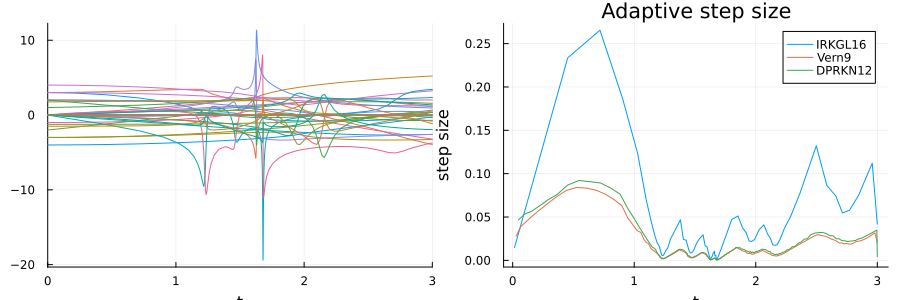

In [14]:
pl1=plot(sol1, label="")


pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(pl2,sol1.t[2:end],steps1, label="IRKGL16")
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot!(pl2,sol9.t[2:end],steps9, label="Vern9")
steps8 =sol8.t[2:end]-sol8.t[1:end-1]
plot!(pl2,sol8.t[2:end],steps8, label="DPRKN12")

plot(pl1,pl2, layout=(1,2), size=(900,300))

### Energy Error

In [15]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialPleiades(BigFloat)


E0=NbodyEnergy(u0256,Gm256)

ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol2.u)./E0.-1;
ΔE9 = map(x->NbodyEnergy3(BigFloat.(x),Gm256), sol9.u)./E0.-1
ΔE8 = map(x->NbodyEnergy4(BigFloat.(x),Gm256), sol8.u)./E0.-1

(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))), Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE8))))

(4.7398578f-14, 2.6246708f-14, 3.7442185f-12, 4.814251f-14)

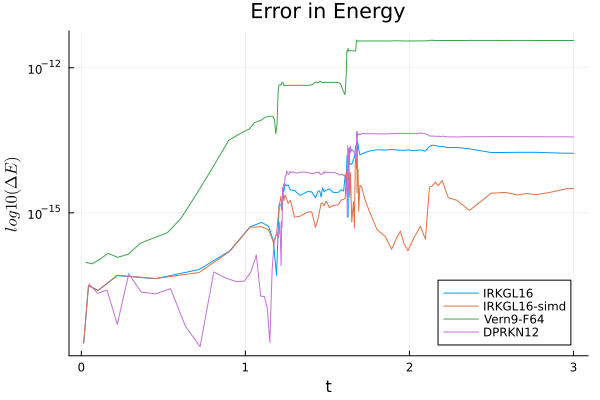

In [16]:
ylimit1=-20
ylimit2=-10
plot(title="Error in Energy", xlabel="t",  ylabel=L"log10(\Delta E)", legend=:bottomright)
plot!(sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16")
plot!(sol2.t[2:end], abs.(ΔE2[2:end]), yscale=:log10, label="IRKGL16-simd")
plot!(sol9.t[2:end], abs.(ΔE9[2:end]), yscale=:log10, label="Vern9-F64")
plot!(sol8.t[2:end], abs.(ΔE8[2:end]), yscale=:log10, label="DPRKN12")

<a href="#top">Back to the top</a>

## Float128 Computations (Second Order ODE)

In [17]:
setprecision(BigFloat, 108);

### IRKGL16 

In [18]:
sol21 = solve(prob128,IRKGL16(second_order_ode=true), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20),adaptive=true)
sol21.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  23952
Number of function 2 evaluations:                  21408
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     2676
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          268
Number of rejected steps:                          50

In [ ]:
@btime solve(prob128,IRKGL16(second_order_ode=true), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20),
       adaptive=true, save_everystep=false);

### Vern9

In [19]:
sol29 = solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20)
sol29.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  38242
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          2390
Number of rejected steps:                          0

In [ ]:
@btime solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20, save_everystep=false);

### DPRKN12

In [20]:
sol28 = solve(prob2nd128,DPRKN12(),abstol=1e-20,reltol=1e-20);
sol28.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  15813
Number of function 2 evaluations:                  931
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          930
Number of rejected steps:                          0

In [ ]:
@btime solve(prob2nd128,DPRKN12(),abstol=1e-20,reltol=1e-20, save_everystep=false);

### Some Plots

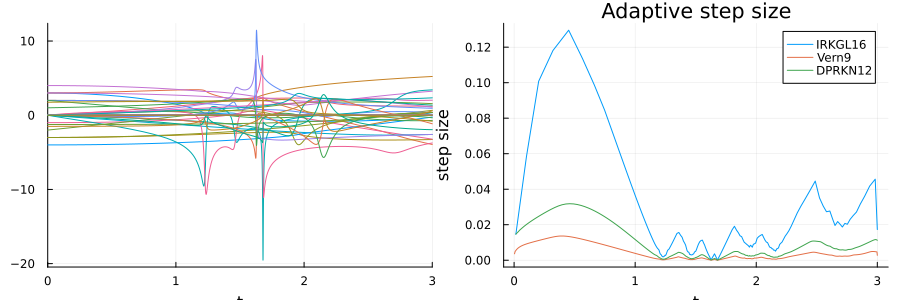

In [21]:
pl1=plot(sol21, label="")

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps21 =sol21.t[2:end]-sol21.t[1:end-1]
plot!(pl2,sol21.t[2:end],steps21, label="IRKGL16")
steps29 =sol29.t[2:end]-sol29.t[1:end-1]
plot!(pl2,sol29.t[2:end],steps29, label="Vern9")
steps28 =sol28.t[2:end]-sol28.t[1:end-1]
plot!(pl2,sol28.t[2:end],steps28, label="DPRKN12")

plot(pl1,pl2, layout=(1,2), size=(900,300))



<a href="#top">Back to the top</a>

## Error in energy

In [22]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialPleiades(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u)./E0.-1;
ΔE29 = map(x->NbodyEnergy3(BigFloat.(x),Gm256), sol29.u)./E0.-1;
ΔE28 = map(x->NbodyEnergy4(BigFloat.(x),Gm256), sol28.u)./E0.-1
(Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE29))) , Float32(maximum(abs.(ΔE28))))

(1.287116f-22, 1.3400625f-20, 2.3496564f-23)

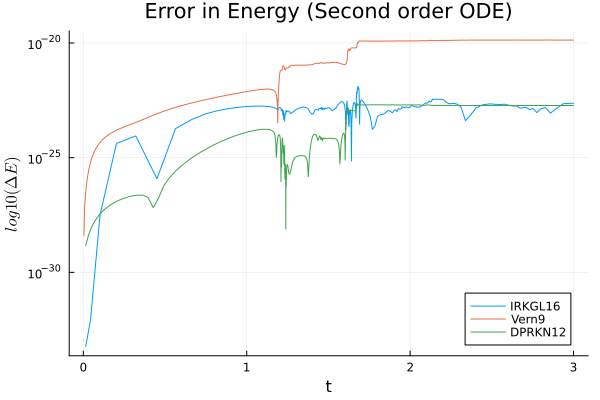

In [23]:
pl1=plot(title="Error in Energy (Second order ODE)", xlabel="t", ylabel=L"log10(\Delta E)", legend=:bottomright)
plot!(pl1, sol21.t[2:end], abs.(ΔE21[2:end]), yscale=:log10, label="IRKGL16")
plot!(pl1, sol29.t[2:end], abs.(ΔE29[2:end]), yscale=:log10, label="Vern9")
plot!(pl1, sol28.t[2:end], abs.(ΔE28[2:end]), yscale=:log10, label="DPRKN12")
